# Testing MPO

In [350]:
%reload_ext autoreload
%autoreload 2
import warnings; warnings.filterwarnings('ignore') 
import rdkit
import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library_sorted.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

Make oracles.

In [381]:
import os

dockstring_dir = f'{path}/dockstring_targets/'
files = os.listdir(dockstring_dir)
configs = sorted([f for f in files if 'conf' in f])
targets = sorted([f for f in files if 'target' in f])

idx = 37
with open(dockstring_dir + configs[idx], 'r') as f:
    config_ = f.readlines()
    config_ = [c.replace('\n', '') for c in config_]
    config_ = [c.split(' = ') for c in config_ if c]
    config_ = {c[0]: float(c[1]) for c in config_}

target = targets[idx]
name = target.split('_')[0]

config_.update({
    'size_x': 22.5,
    'size_y': 22.5,
    'size_z': 22.5,
})

from dgym.envs.oracle import DockingOracle, CatBoostOracle, RDKitOracle, NoisyOracle
from dgym.envs.utility import ClassicUtilityFunction

config = {
    'search_mode': 'detailed',
    'scoring': 'vina',
    'seed': 5,
    **config_
}

docking_oracle = DockingOracle(
    f'{name} affinity',
    receptor_path=f'{path}/dockstring_targets/{name}_target.pdbqt',
    config=config
)
log_P_oracle = RDKitOracle('MolLogP')
log_S_oracle = CatBoostOracle('Log S', path='../../dgym-data/models/aqsolcb.model')

# create evaluators
docking_cost_function = ClassicUtilityFunction(
    docking_oracle,
    ideal=(8, 9.5),
    acceptable=(7.7, 9.5)
)

log_P_cost_function = ClassicUtilityFunction(
    log_P_oracle,
    ideal=(0.5, 1.85),
    acceptable=(-0.5, 3.5)
)

log_S_cost_function = ClassicUtilityFunction(
    log_S_oracle,
    ideal=(-1, 1),
    acceptable=(-4, 1)
)

assays = [
    docking_oracle,
    log_P_oracle,
    log_S_oracle
]

cost_functions = [
    docking_cost_function,
    log_P_cost_function,
    log_S_cost_function
]

Instantiate designer.

In [382]:
from dgym.envs.designer import Designer, Generator

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

Pick 5 random starting hits.

In [383]:
# select first molecule
import random
def select_molecule(deck):
    initial_index = random.randint(0, len(deck) - 1)
    initial_molecule = deck[initial_index]
    if len(initial_molecule.reactants) == 2 \
        and designer.match_reactions(initial_molecule):
        return initial_molecule
    else:
        return select_molecule(deck)

initial_molecules = [select_molecule(deck) for _ in range(5)]
initial_library = dg.MoleculeCollection(initial_molecules)
initial_library.update_annotations()
library = initial_library

Prepare MPO ranking function.

In [384]:
import numpy as np
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

def rank_molecules(costs):
    
    costs = np.nan_to_num(costs)

    # Multi-dimensional non-dominated fusion sort
    nds, nds_ranks = NonDominatedSorting().do(
        costs, return_rank=True, only_non_dominated_front=False)
    penalty_sums = np.sum(costs, axis=1)
    fused_ranks = np.lexsort([penalty_sums, nds_ranks]) # prioritizes last column
    
    return fused_ranks.tolist()

Multi-step selection.

In [379]:
import numpy as np
from tqdm.notebook import tqdm

for molecule in library:
    molecule.update_annotations(
        {'timestep': 0, **{a.name: a(molecule) for a in assays}})

costs = np.asarray([cost(library) for cost in cost_functions[:2]]).T
ranking = rank_molecules(costs)
best = ranking

print([cost(library[best]) for cost in cost_functions])
print(best)

for step in tqdm(range(1, 10)):
    
    analogs = []
    for b in best:
        if step % 5 == 2:
            analogs += designer.design(
                library[b], 8, strategy='grow')
        else:
            analogs += designer.design(
                library[b], 8, strategy='replace', temperature=0.0)

    # Get costs
    library += analogs
    costs = np.asarray([cost(library) for cost in cost_functions]).T

    ranking = rank_molecules(costs)
    best = ranking[:5]
    # best = np.random.choice(len(costs))

    for analog in analogs:
        analog.update_annotations(
            {'timestep': step, **{a.name: a(analog) for a in assays}})

    print(step, costs[best])
    print(step, best)

[array([60.139851  , 59.95836108, 60.18205603, 60.18205603, 60.18205603]), array([0.        , 0.53963636, 0.        , 0.002     , 0.21260606]), array([0.46830958, 0.79540317, 0.35800586, 0.19307392, 0.55568325])]
[4, 3, 0, 2, 1]


  0%|          | 0/9 [00:00<?, ?it/s]

1 [[59.57540458  0.          0.31244596]
 [59.84304334  0.          0.24438245]
 [60.18205603  0.          0.07753776]
 [60.18205603  0.          0.0901746 ]
 [60.01058156  0.          0.35607266]]
1 [31, 24, 32, 34, 22]
2 [[59.57540458  0.          0.31244596]
 [59.84304334  0.          0.24438245]
 [60.18205603  0.          0.07753776]
 [60.18205603  0.          0.0901746 ]
 [60.01058156  0.          0.35607266]]
2 [31, 24, 32, 34, 22]
3 [[5.95754046e+01 0.00000000e+00 3.12445956e-01]
 [5.98430433e+01 0.00000000e+00 2.44382452e-01]
 [6.01820560e+01 0.00000000e+00 3.55183865e-02]
 [6.01180798e+01 0.00000000e+00 2.35021887e-01]
 [6.01140705e+01 6.79000000e-02 2.04233994e-01]]
3 [31, 24, 107, 92, 79]
4 [[5.95754046e+01 0.00000000e+00 3.12445956e-01]
 [5.95238287e+01 0.00000000e+00 5.36361147e-01]
 [5.98430433e+01 0.00000000e+00 2.44382452e-01]
 [6.01857912e+01 0.00000000e+00 1.04267873e-02]
 [6.00988747e+01 0.00000000e+00 1.04014205e-01]]
4 [31, 148, 24, 138, 126]
5 [[5.95754046e+01 0.0

# Visualizing results

Text(0.5, 1.0, 'Heavy atom count vs. pIC50')

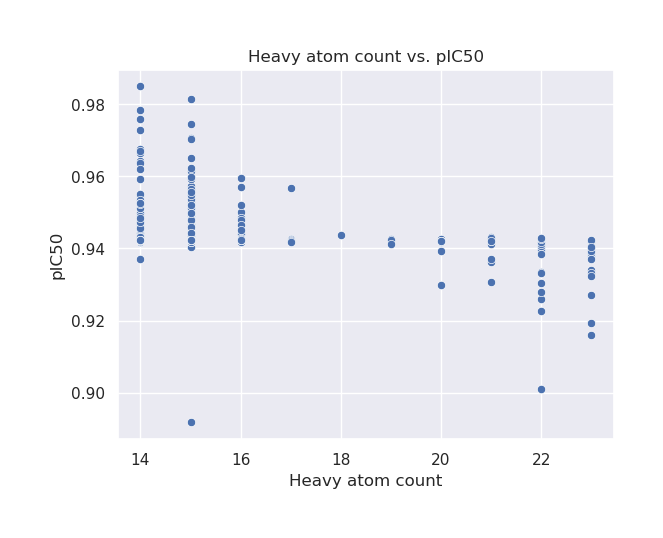

In [380]:
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem.Descriptors import HeavyAtomCount

sns.set()
sns.scatterplot(
    x=[HeavyAtomCount(m.mol) for m in library],
    y=docking_oracle(library),
)

plt.xlabel('Heavy atom count')
plt.ylabel('pIC50')
plt.title('Heavy atom count vs. pIC50')

<Figure size 1920x1440 with 0 Axes>

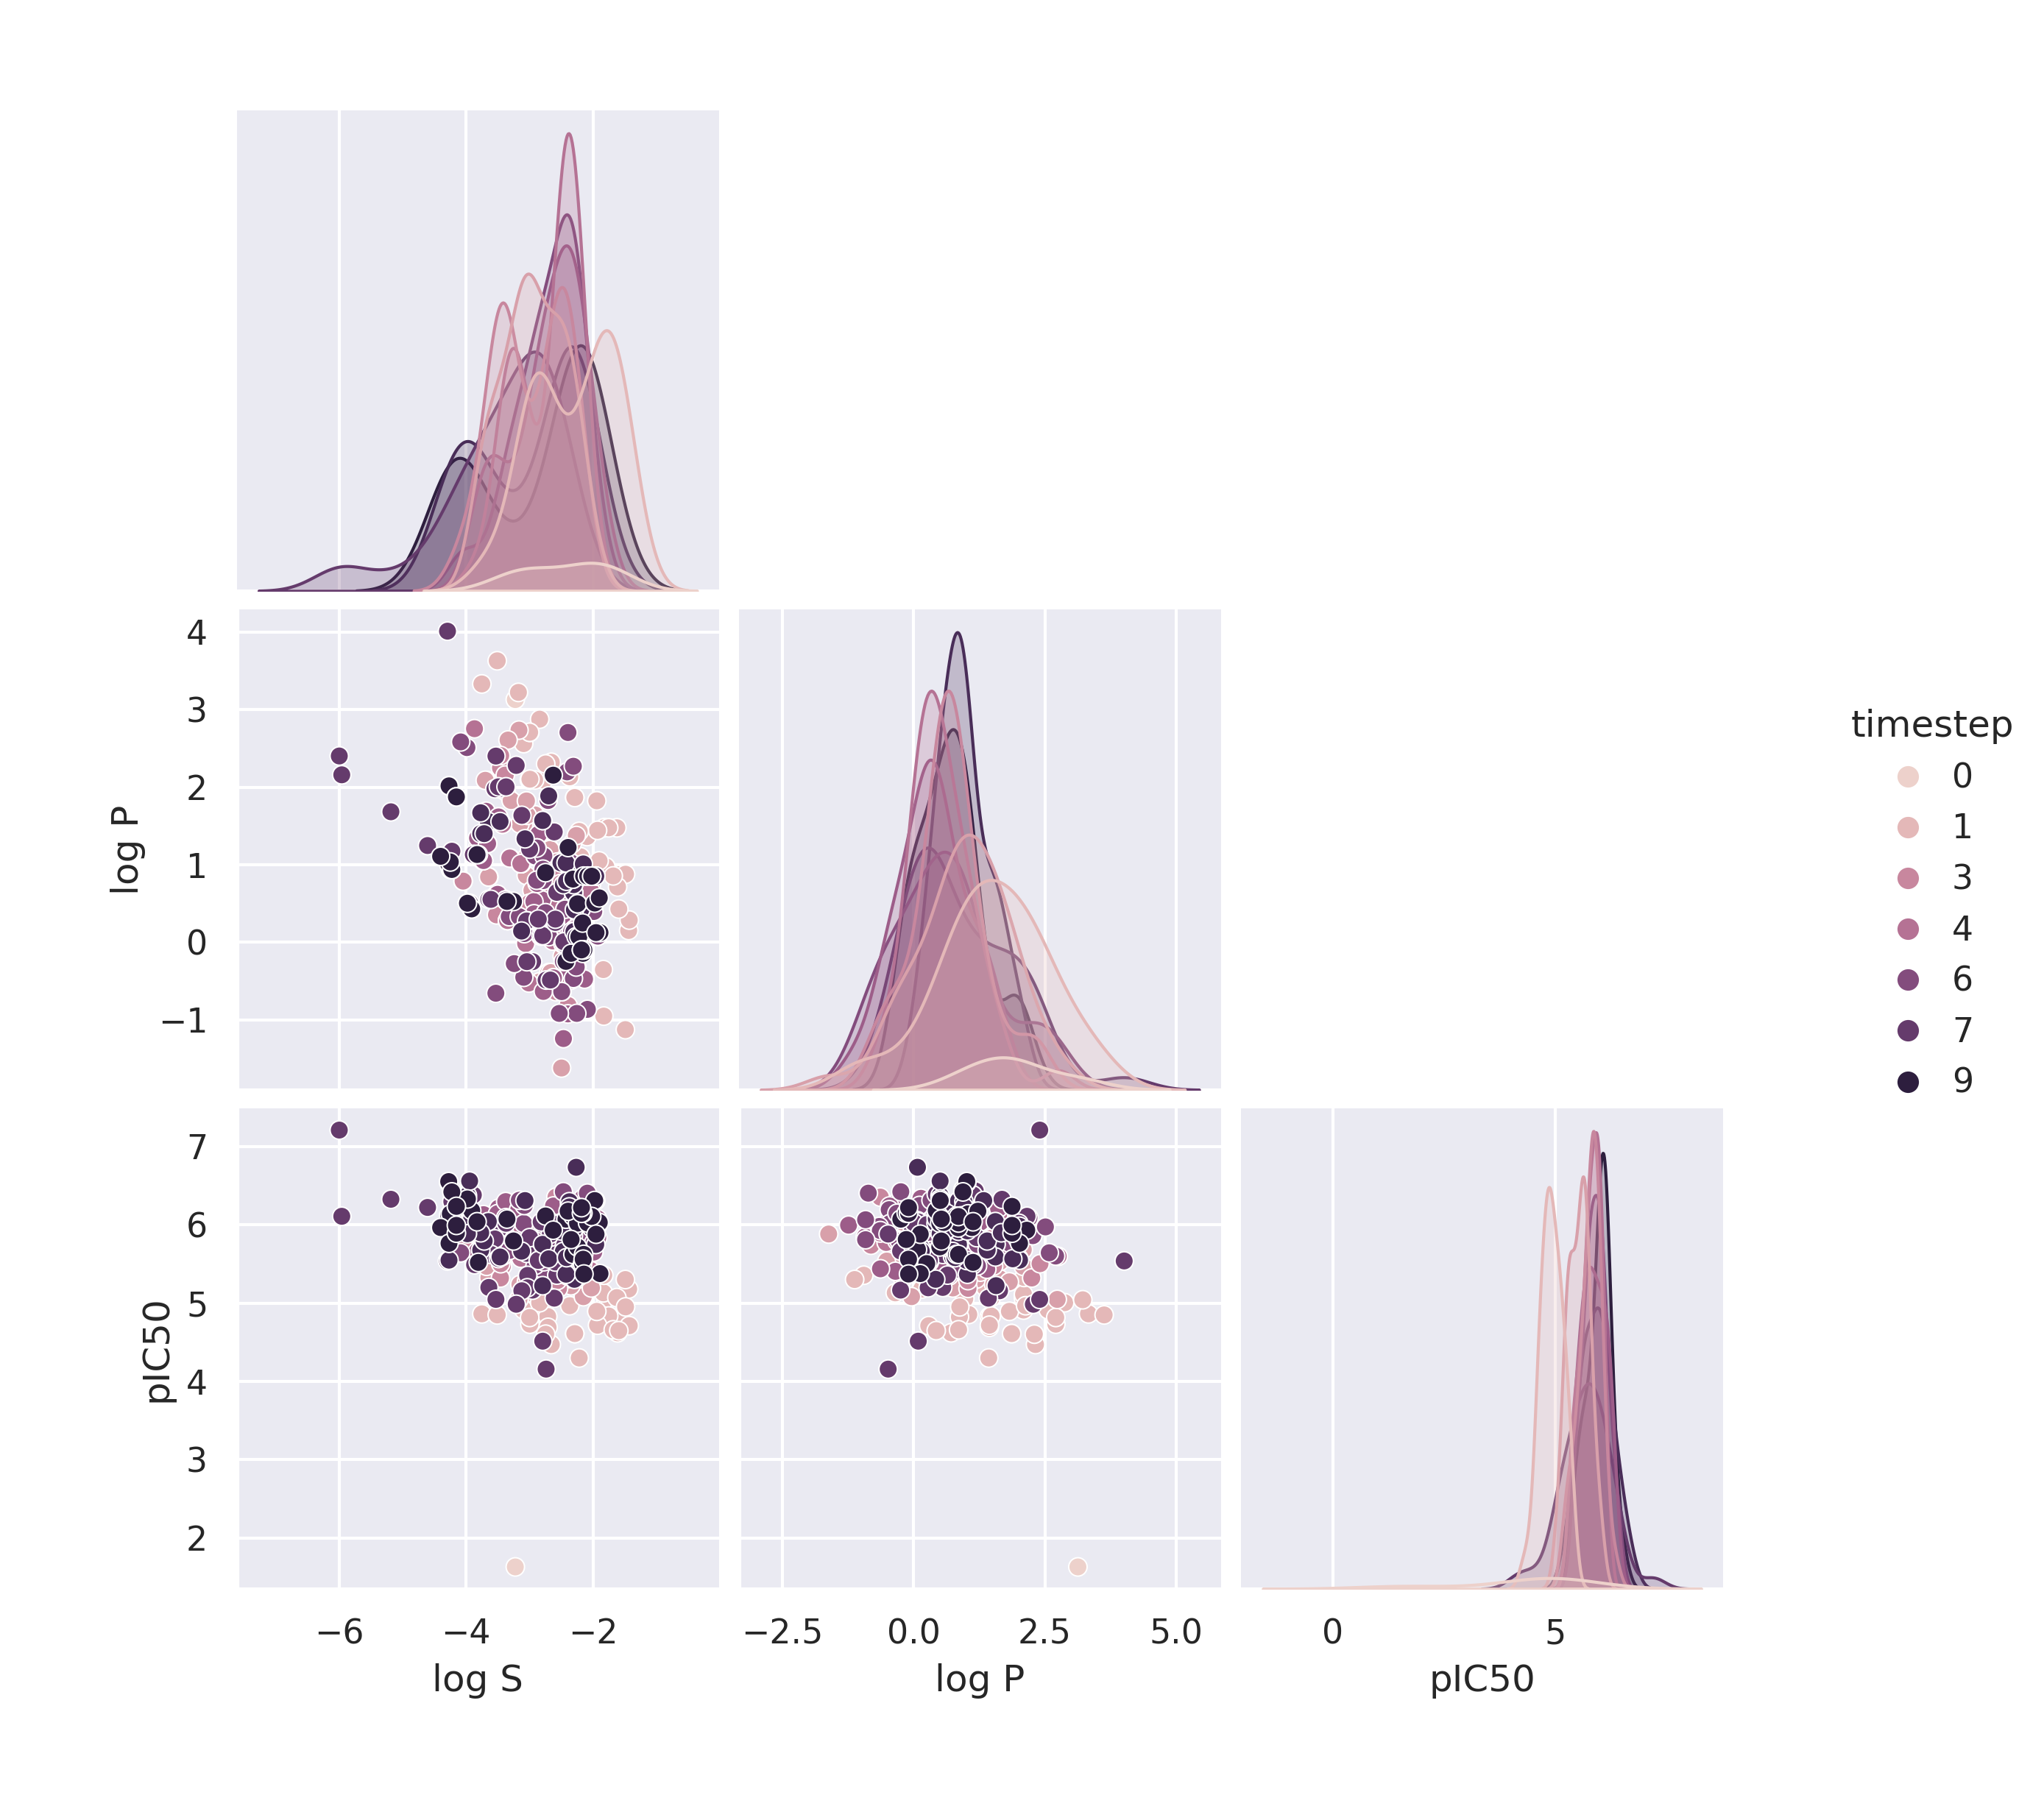

In [314]:
import pandas as pd

plt.figure(dpi=300)

sns.set_theme()
g = sns.pairplot(
    pd.DataFrame([{
        'log S': log_S_oracle(l)[0],
        'log P': log_P_oracle(l)[0],
        'pIC50': docking_oracle(l)[0],
        'timestep': l.annotations['timestep']
    } for l in library]),
    corner=True,
    hue='timestep'
)
g.fig.set_dpi(300)

## Visualizing the best across rounds

A trajectory of the best molecule each round.

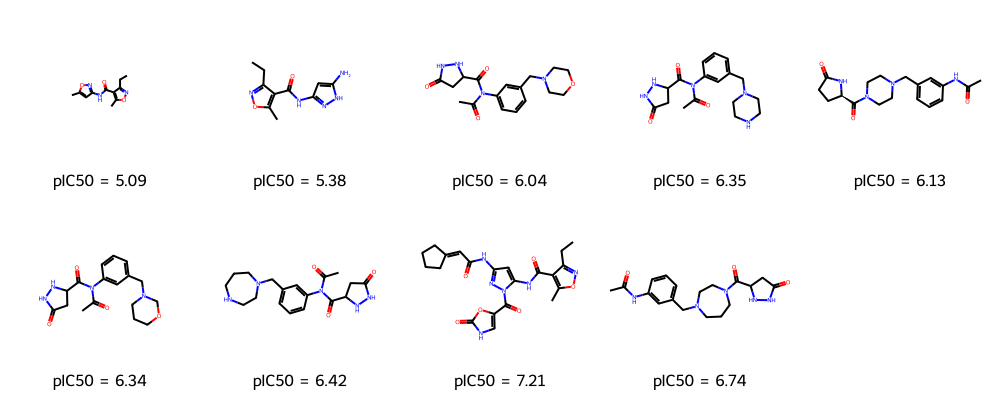

In [315]:
best_across_round = [
    library.annotations.query(f'timestep == {i}')['CASP3 affinity']
    .sort_values(na_position='first')
    .index[-1].item()
    for i in range(int(library.annotations.timestep.max()))
    if library.annotations.query(f'timestep == {i}')['CASP3 affinity'].any()
]

from rdkit.Chem.Draw import MolsToGridImage

get_affinity = lambda idx: library[idx]['CASP3 affinity'][0]
MolsToGridImage(
    [m.mol for m in library[best_across_round]],
    molsPerRow=5,
    legends=[f'pIC50 = {round(get_affinity(b), 2)}' for b in best_across_round]
)

A trajectory of the best molecule.

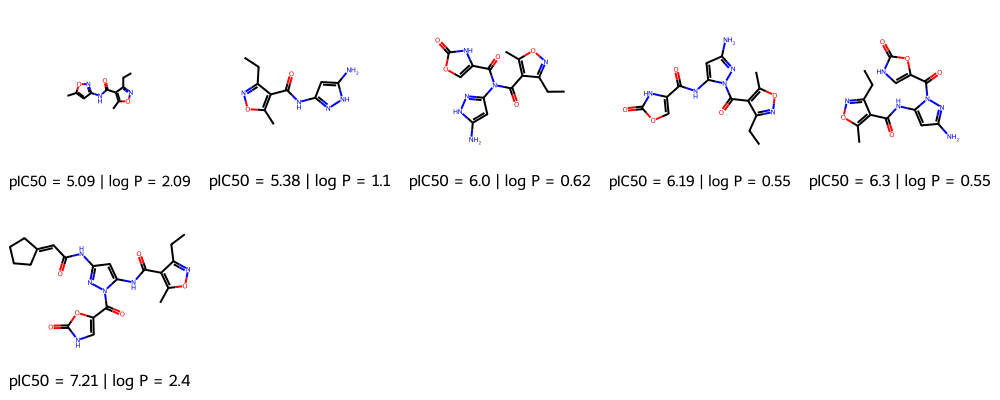

In [316]:
mol = library[np.nanargmax(docking_oracle(library)).item()]
milestones = [mol]
while mol.inspiration:
    milestones.append(mol.inspiration)
    mol = mol.inspiration
    
milestones = list(reversed(milestones))

MolsToGridImage(
    [m.mol for m in milestones],
    molsPerRow=5,
    legends=[f'pIC50 = {round(docking_oracle(m)[0], 2)} | log P = {round(log_P_oracle(m)[0], 2)}' for m in milestones]
)

Text(0.5, 1.0, 'New compounds synthesized each round')

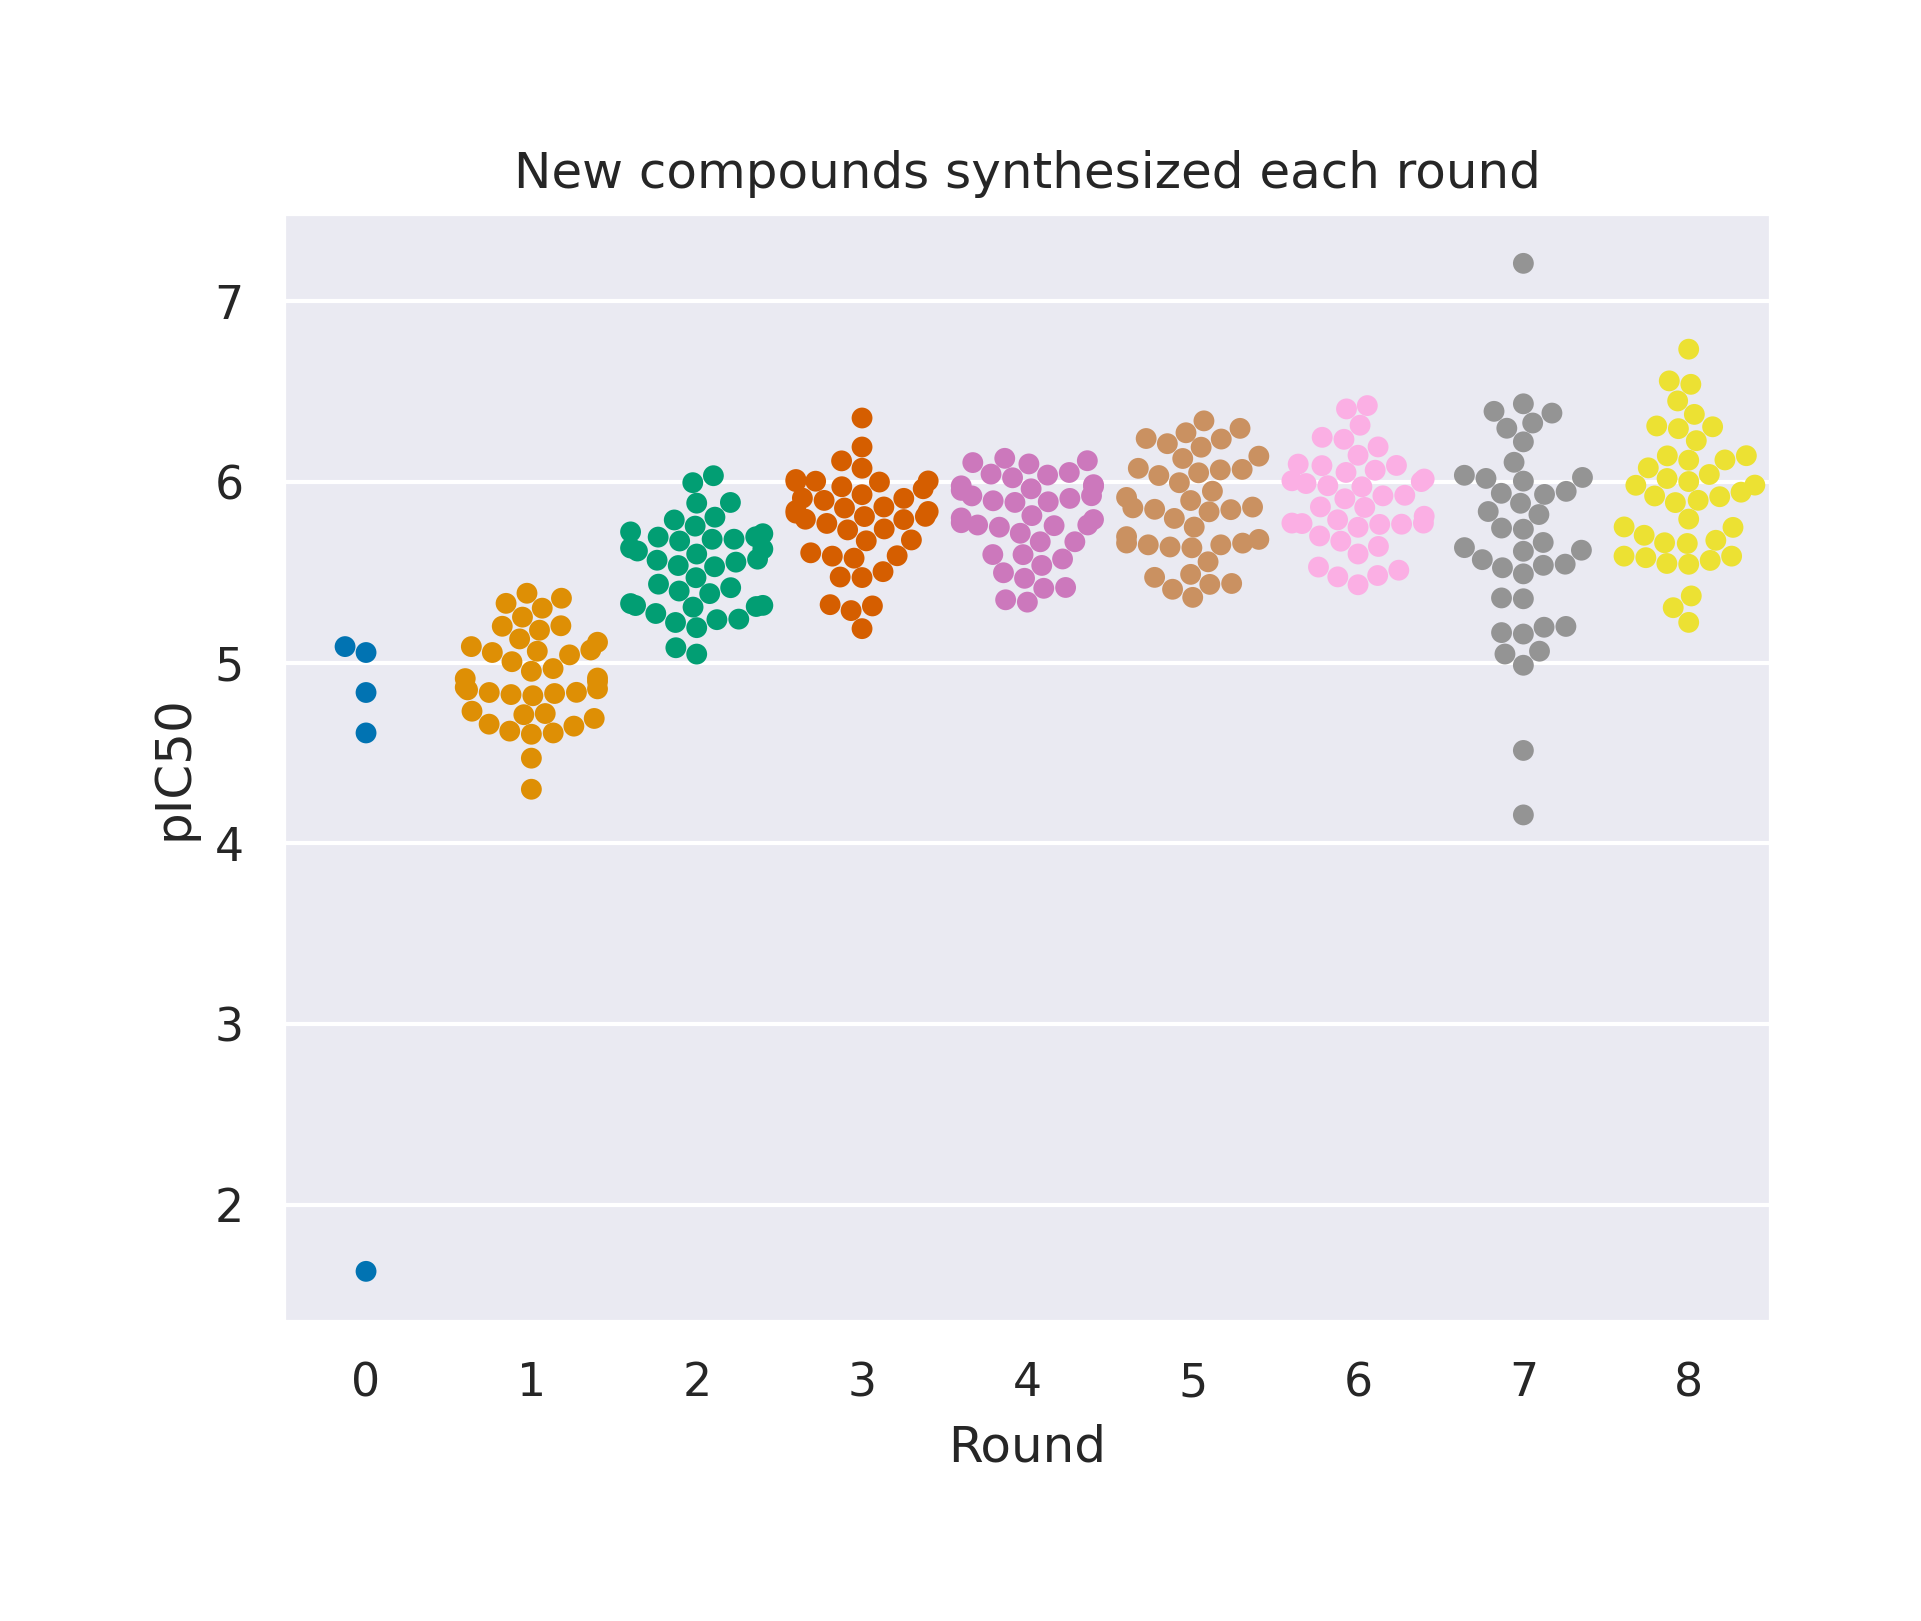

In [317]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(dpi=300)
sns.set()

objective = 'CASP3 affinity'
annotations = library.annotations.iloc[:-40]
annotations[objective] = [l[0] for l in annotations[objective]]

sns.swarmplot(
    annotations,
    x='timestep',
    y=objective,
    hue='timestep',
    palette='colorblind',
    # complementary=True,
    legend=False
)

plt.ylabel('pIC50')
plt.xlabel('Round')
plt.title('New compounds synthesized each round')

In [318]:
max_timestep = int(library.annotations.timestep.max())

records = []
for timestep, group in library.annotations.groupby('timestep'):
    for _, mol in group.iterrows():
        record = {'pIC50': mol['CASP3 affinity'][0], 'timestep': timestep}
        records.append(record)
        
        # Duplicate logic for each possible timestep
        for t in range(1, max_timestep + 1):
            if timestep < t:
                records.append({**record, 'timestep': t})

df = pd.DataFrame(records)

Text(0.5, 1.0, 'Distribution of ligand potencies across rounds')

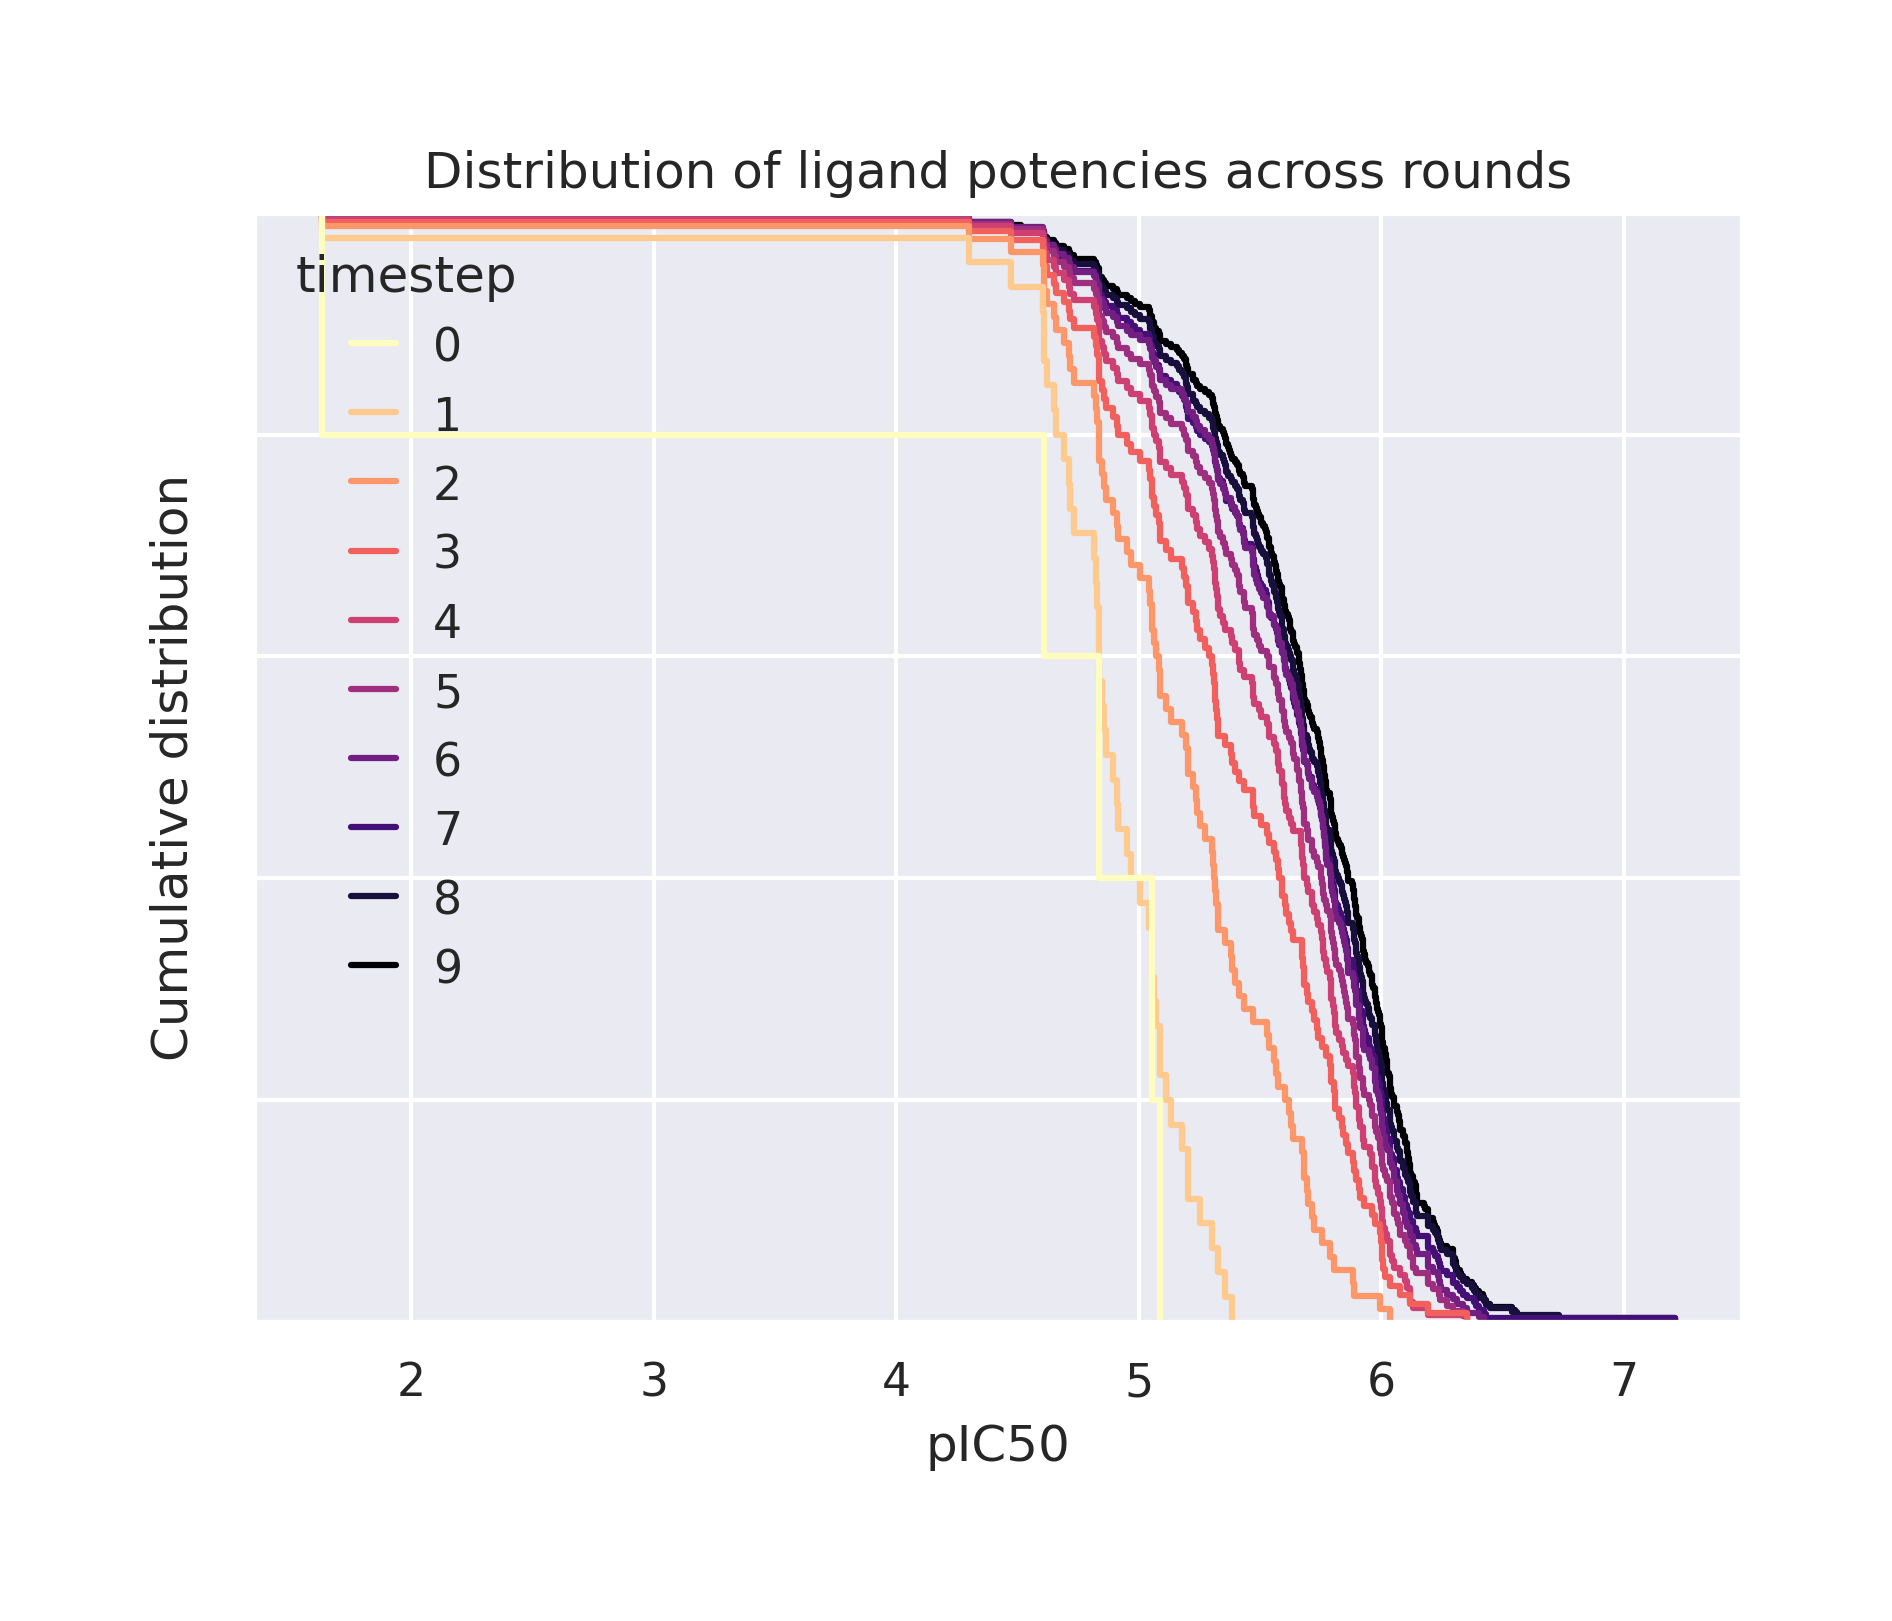

In [319]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.figure(dpi=300)

g = sns.ecdfplot(
    df,
    x='pIC50',
    hue='timestep',
    palette='magma_r',
    complementary=True
)

g.set(yticklabels=[])

plt.xlabel('pIC50')
plt.ylabel('Cumulative distribution')
plt.title('Distribution of ligand potencies across rounds')

Text(0.5, 1.0, 'Assay values across time')

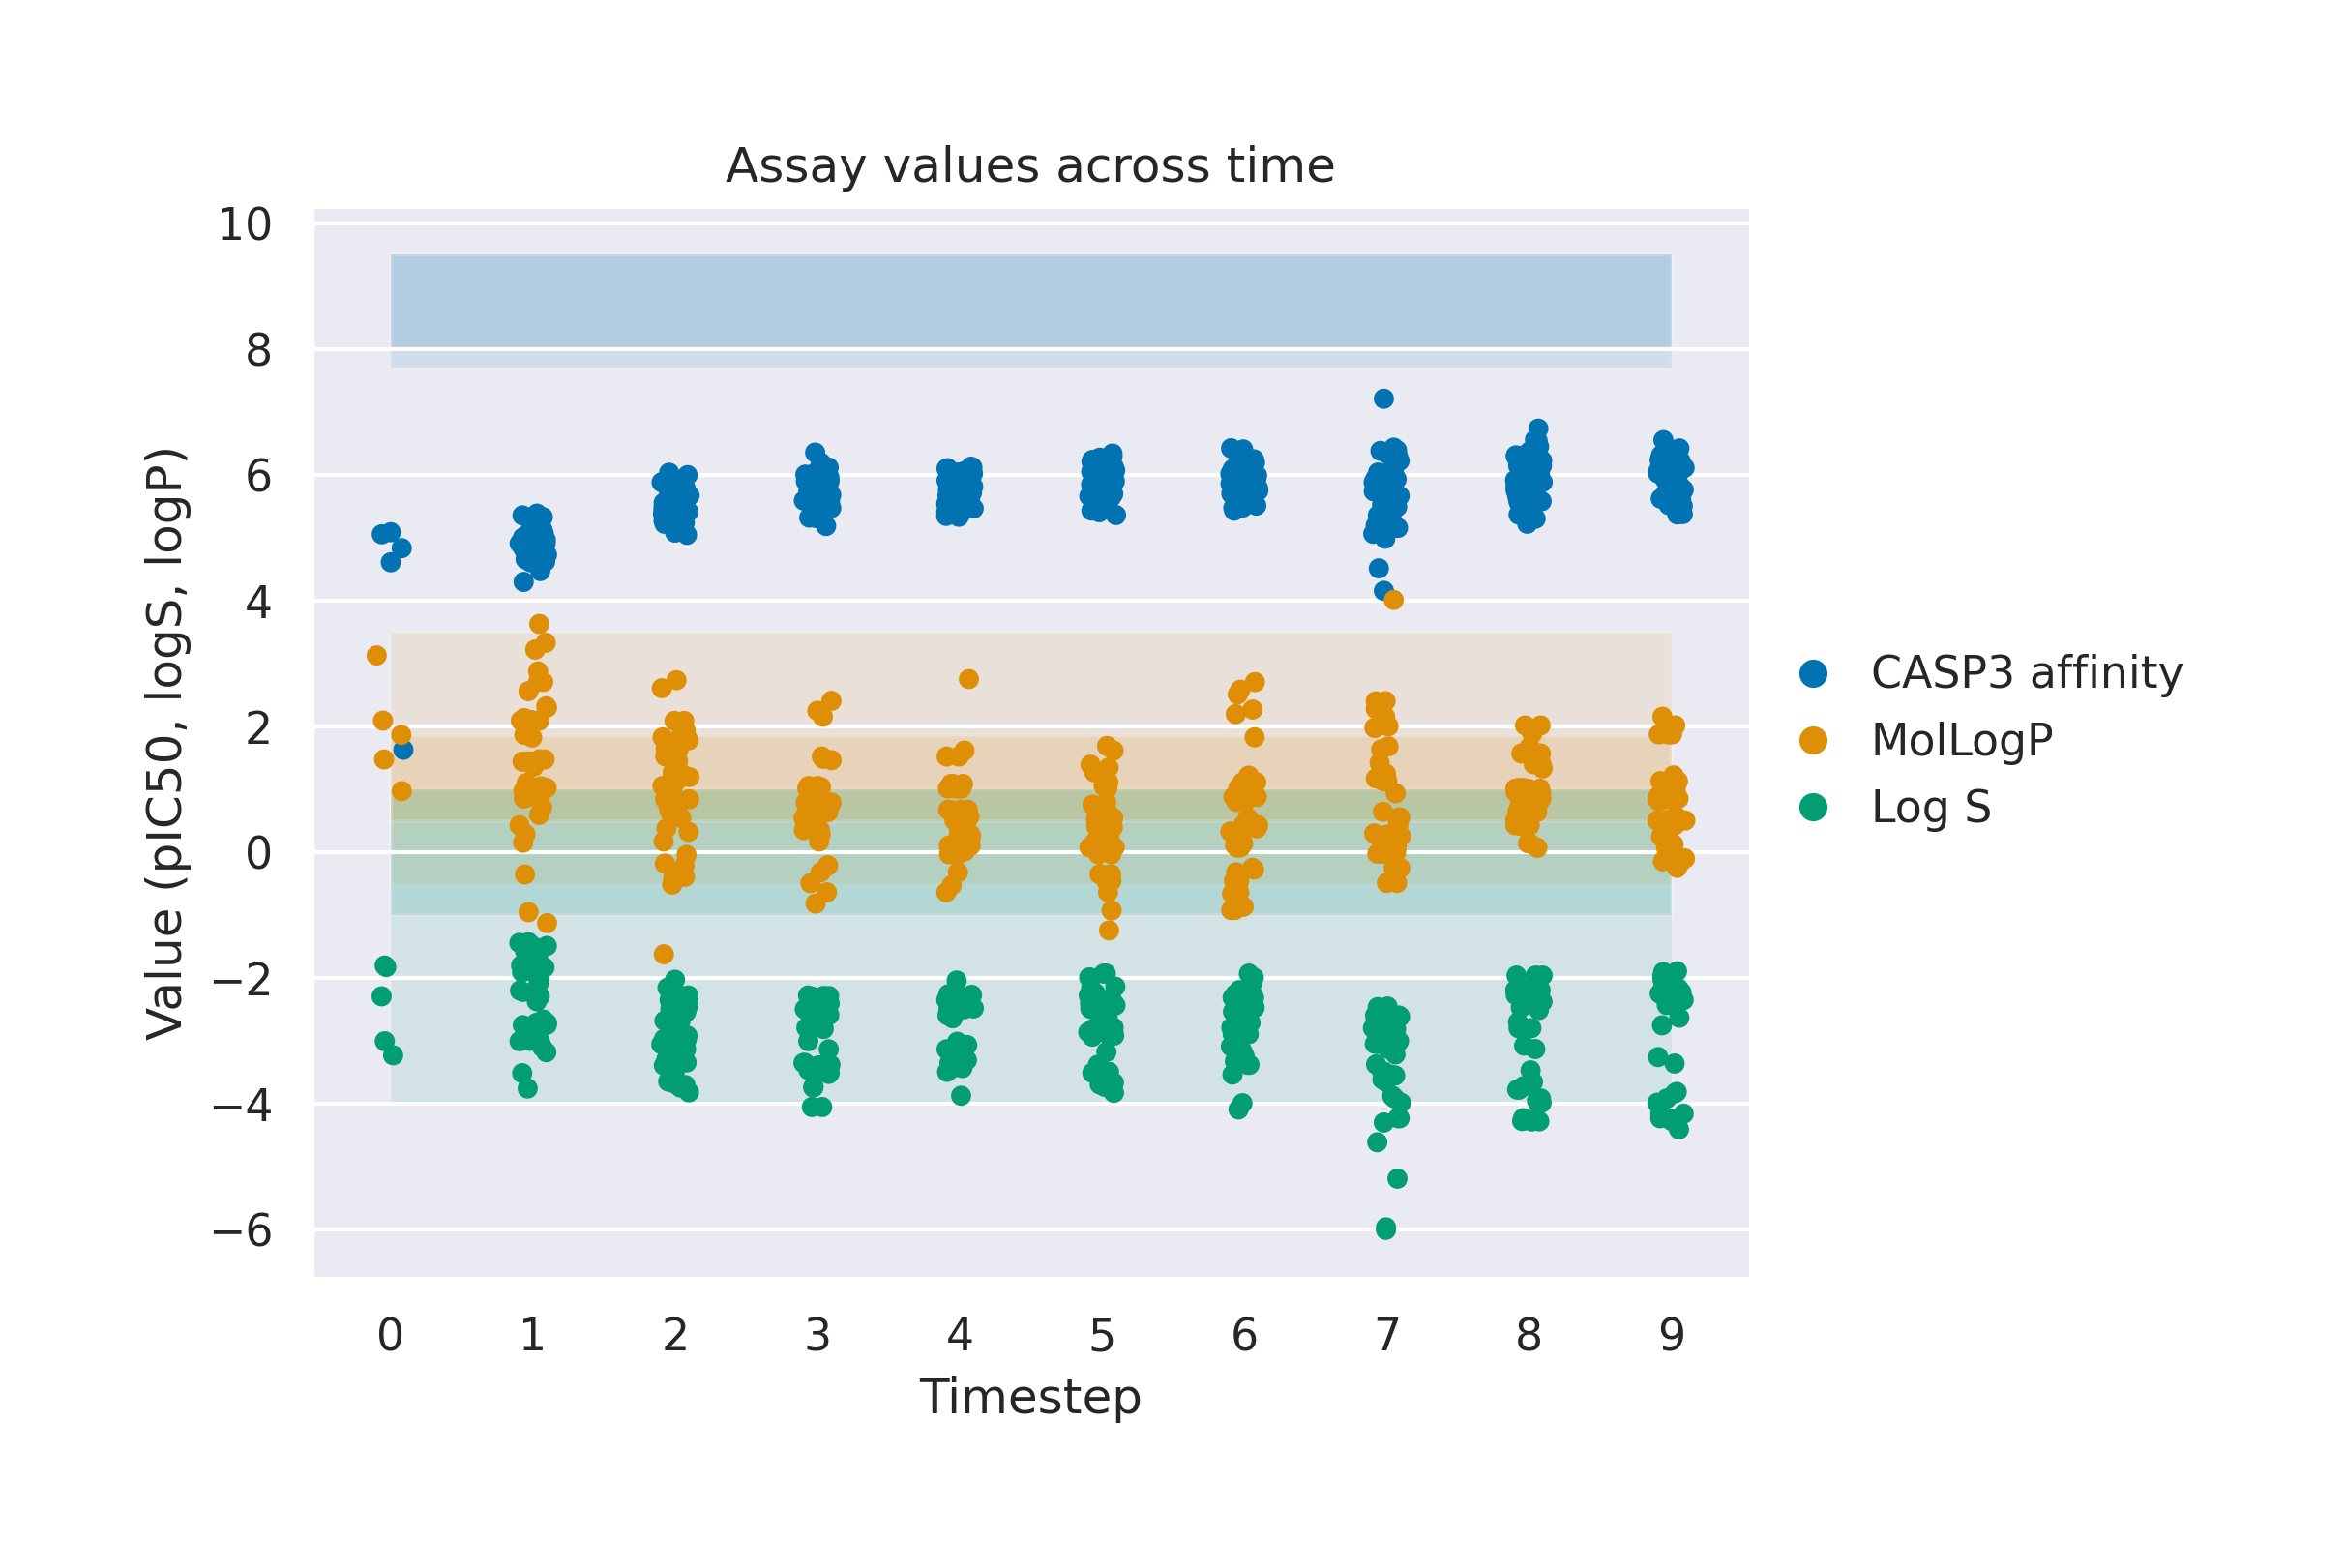

In [320]:
plt.figure(dpi=300)
sns.set_theme()

annotations = (
    library.annotations
    .map(lambda x: x[0] if isinstance(x, list) else x)
    [['timestep', 'CASP3 affinity', 'MolLogP', 'Log S']]
)

annotations = pd.melt(
    annotations,
    id_vars=['timestep'],
    var_name='assay',
    value_name='value'
)

g = sns.stripplot(
    annotations,
    x='timestep',
    y='value',
    hue='assay',
    palette='colorblind'
)

plt.fill_betweenx(
    log_S_cost_function.acceptable, 0, annotations.timestep.max(), alpha=0.1, zorder=-10,
    facecolor=sns.palettes.color_palette('colorblind')[2]
)
plt.fill_betweenx(
    log_P_cost_function.acceptable, 0, annotations.timestep.max(), alpha=0.1, zorder=-10,
    facecolor=sns.palettes.color_palette('colorblind')[1]
)
plt.fill_betweenx(
    docking_cost_function.acceptable, 0, annotations.timestep.max(), alpha=0.1, zorder=-10,
    facecolor=sns.palettes.color_palette('colorblind')[0]
)

plt.fill_betweenx(
    log_S_cost_function.ideal, 0, annotations.timestep.max(), alpha=0.15, zorder=-10,
    facecolor=sns.palettes.color_palette('colorblind')[2]
)
plt.fill_betweenx(
    log_P_cost_function.ideal, 0, annotations.timestep.max(), alpha=0.15, zorder=-10,
    facecolor=sns.palettes.color_palette('colorblind')[1]
)
plt.fill_betweenx(
    docking_cost_function.ideal, 0, annotations.timestep.max(), alpha=0.15, zorder=-10,
    facecolor=sns.palettes.color_palette('colorblind')[0]
)

g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Timestep')
plt.ylabel('Value (pIC50, logS, logP)')
plt.title('Assay values across time')

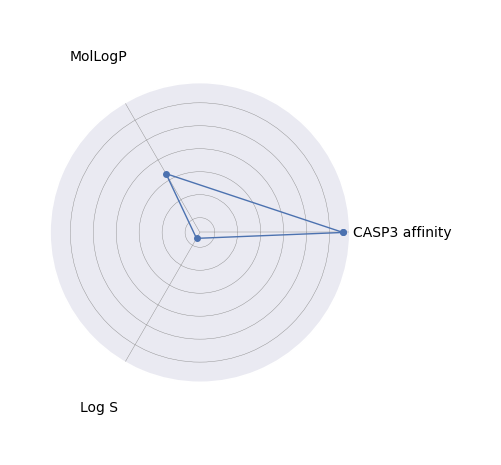

In [277]:
from radar import radar_chart
import matplotlib.pyplot as plt

annotations = (
    library.annotations.map(
    lambda x: x[0] if isinstance(x, list) else x)
    [['CASP3 affinity', 'MolLogP', 'Log S']]
)

labels = annotations.columns
values = annotations.iloc[0]

radar_chart(
    labels=labels, values=values, fill_alpha=0)
plt.show()

Docking on-disk.

In [344]:
[m.smiles for m in milestones]

['CCc1noc(C)c1C(=O)Nc1cc(C)on1',
 'CCc1noc(C)c1C(=O)Nc1cc(N)[nH]n1',
 'CCc1noc(C)c1C(=O)N(C(=O)c1coc(=O)[nH]1)c1cc(N)[nH]n1',
 'CCc1noc(C)c1C(=O)n1nc(N)cc1NC(=O)c1coc(=O)[nH]1',
 'CCc1noc(C)c1C(=O)Nc1cc(N)nn1C(=O)c1c[nH]c(=O)o1',
 'CCc1noc(C)c1C(=O)Nc1cc(NC(=O)C=C2CCCC2)nn1C(=O)c1c[nH]c(=O)o1']

In [349]:
import math
-10 * (-math.log10(math.e) / 0.6)

7.238241365054198

In [342]:
results = docking_oracle(
    milestones,
    path='../../dgym-data/out/docking_results',
    use_cache=False
)

[
    [
        "CCc1noc(C)c1C(=O)Nc1cc(NC(=O)C=C2CCCC2)nn1C(=O)c1c[nH]c(=O)o1",
        -9.42174411924525
    ],
    [
        "CCc1noc(C)c1C(=O)n1nc(N)cc1NC(=O)c1coc(=O)[nH]1",
        -8.135770256991226
    ],
    [
        "CCc1noc(C)c1C(=O)Nc1cc(C)on1",
        -7.0011425060195975
    ],
    [
        "CCc1noc(C)c1C(=O)Nc1cc(N)nn1C(=O)c1c[nH]c(=O)o1",
        -8.5584400154695
    ],
    [
        "CCc1noc(C)c1C(=O)N(C(=O)c1coc(=O)[nH]1)c1cc(N)[nH]n1",
        -8.150959796096224
    ],
    [
        "CC(CNC(=O)c1ccc(O)cc1O)N(C(=O)c1ccc(F)o1)C(=O)C1(C)CCN1",
        -7.956951343372502
    ],
    [
        "CCc1noc(C)c1C(=O)Nc1cc(N)[nH]n1",
        -7.246143455313148
    ],
    [
        "CC(CNC(=O)c1ccc(O)cc1O)NC(=O)c1ccc(F)o1",
        -7.781865812772612
    ]
]


In [331]:
docking_oracle(milestones)

[5.089201921021175,
 5.384512173397103,
 5.996653779449743,
 6.194023600677443,
 6.297247200467275,
 7.210686892728179]

In [332]:
len(milestones)

6

In [338]:
results

[6.586932509408443,
 6.070544375327253,
 5.233455284306836,
 6.3500845789207885,
 5.696174465208034,
 5.759433435332241,
 5.178583312566241,
 5.632702302331182]